# Final Task: Minimazing Credit Risk Through Client Classification
# Project Based Internship ID/X Partners x Rakamin Academy

Objective:
- Improve accuracy in assessing and managing credit risk
- Reduce potential losses by reduce the default rate


## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway 
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

import re
import warnings
warnings.filterwarnings("ignore")

## 2. Load Data & Data Understanding

### Load and Split

In [2]:
# load the dataset
df = pd.read_csv("../Data/loan_data_2007_2014.csv", low_memory=False)

# split data by categorical and numeric
categoric = df.select_dtypes("object")
numeric = df.select_dtypes("number")

# split data by rows and columns
rows = df.shape[0]
cols = df.shape[1]

In [3]:
# display data shape
print("Data shape:")
print(f"Number of rows: {rows} \nNumber of columns: {cols}")

Data shape:
Number of rows: 466285 
Number of columns: 75


### Data Overview

In [4]:
# display data overview
print("Data overview:")
display(df.sample(3))

Data overview:


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
210755,210755,1385869,1631584,5000,5000,5000.0,36 months,15.31,174.09,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295587,295587,29033673,31556859,2100,2100,2100.0,36 months,14.99,72.79,C,...,NaN,NaN,NaN,NaN,NaN,NaN,12700.0,NaN,NaN,NaN
205406,205406,1447072,1699486,10000,10000,10000.0,36 months,12.12,332.72,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# display categorical data summary
print("Categorical data summary:")
display(categoric.describe())

Categorical data summary:


,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
count,466285,466285,466285,438697,445277,466285,466285,466285,466285,466285,...,466285,466264,466285,466285,466256,466285,465909,239071,466243,466285
unique,2,7,35,205475,11,6,3,91,9,2,...,14,63098,888,50,664,2,98,100,103,1
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-14,Current,n,...,debt_consolidation,Debt consolidation,945xx,CA,Oct-00,f,Jan-16,Feb-16,Jan-16,INDIVIDUAL
freq,337953,136929,31686,5399,150049,235875,168055,38782,224226,466276,...,274195,164075,5304,71450,3674,303005,179620,208393,327699,466285


In [6]:
# display numerical data summary
print("Numerical data summary:")
display(numeric.describe())

Numerical data summary:


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,466285.000000,4.662850e+05,4.662850e+05,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.960090e+05,0.0,0.0,0.0
mean,233142.000000,1.307973e+07,1.459766e+07,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,...,NaN,NaN,NaN,NaN,NaN,NaN,3.037909e+04,NaN,NaN,NaN
std,134605.029472,1.089371e+07,1.168237e+07,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,...,NaN,NaN,NaN,NaN,NaN,NaN,3.724713e+04,NaN,NaN,NaN
min,0.000000,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
25%,116571.000000,3.639987e+06,4.379705e+06,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.350000e+04,NaN,NaN,NaN
50%,233142.000000,1.010790e+07,1.194108e+07,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,...,NaN,NaN,NaN,NaN,NaN,NaN,2.280000e+04,NaN,NaN,NaN
75%,349713.000000,2.073121e+07,2.300154e+07,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,...,NaN,NaN,NaN,NaN,NaN,NaN,3.790000e+04,NaN,NaN,NaN
max,466284.000000,3.809811e+07,4.086083e+07,35000.000000,35000.000000,35000.000000,26.060000,1409.990000,7.500000e+06,39.990000,...,NaN,NaN,NaN,NaN,NaN,NaN,9.999999e+06,NaN,NaN,NaN


### Types of Data

In [7]:
# checking for types of data
with pd.option_context("display.max_rows", None):
    print(df.dtypes)

Unnamed: 0                       int64
id                               int64
member_id                        int64
loan_amnt                        int64
funded_amnt                      int64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                         object
loan_status                     object
pymnt_plan                      object
url                             object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                      

### Data Review

In [8]:
# Review all categorical data values
for col in categoric.columns:
    print(categoric[col].value_counts())
    print("-"*35,"*"*3)

term
36 months    337953
60 months    128332
Name: count, dtype: int64
----------------------------------- ***
grade
B    136929
C    125293
D     76888
A     74867
E     35757
F     13229
G      3322
Name: count, dtype: int64
----------------------------------- ***
sub_grade
B3    31686
B4    30505
C1    26953
C2    26740
B2    26610
C3    25317
B5    25252
C4    24105
B1    22876
C5    22178
A5    21757
D1    19261
A4    19045
D2    17046
D3    14916
D4    14099
A3    12568
D5    11566
A2    10956
A1    10541
E1     9033
E2     8669
E3     6976
E4     5992
E5     5087
F1     3940
F2     3001
F3     2708
F4     2067
F5     1513
G1     1109
G2      823
G3      583
G4      422
G5      385
Name: count, dtype: int64
----------------------------------- ***
emp_title
Teacher                              5399
Manager                              4438
Registered Nurse                     2316
RN                                   2204
Supervisor                           1967
                 

In [9]:
# Review all numerical data values
for col in numeric.columns:
    print(numeric[col].value_counts())
    print("-"*35,"*"*3)

Unnamed: 0
0         1
310839    1
310865    1
310864    1
310863    1
         ..
155424    1
155423    1
155422    1
155421    1
466284    1
Name: count, Length: 466285, dtype: int64
----------------------------------- ***
id
1077501     1
26180404    1
26219322    1
26239577    1
26290537    1
           ..
3714715     1
3703738     1
3731030     1
3705772     1
9199665     1
Name: count, Length: 466285, dtype: int64
----------------------------------- ***
member_id
1296599     1
28653081    1
28692177    1
28702376    1
28763241    1
           ..
4686866     1
4847180     1
4724047     1
4678105     1
11061576    1
Name: count, Length: 466285, dtype: int64
----------------------------------- ***
loan_amnt
10000    33023
12000    25519
15000    23486
20000    22759
35000    16596
         ...  
34250        1
33400        1
32150        1
34325        1
33175        1
Name: count, Length: 1352, dtype: int64
----------------------------------- ***
funded_amnt
10000    32930
12000   

### Columns Issue

Based on the data review, there are several columns that have problems:
#### `1. Imbalanced columns`
Here are the columns with Imbalanced data:
- pymnt_plan

#### `2. High cardinality columns`
Here are the columns that have too many unique values:
- emp_title
- title
- zip_code
- url
- desc

#### `3. Low cardinality columns`
Here are the column that has too few unique values:
- application_type
- policy_code
- acc_now_delinq

Here are the columns that are possible to generalize:
- addr_state

#### `4. Unnecessary columns`
Here are the column that will not be included in the model:
- Unnamed: 0
- id
- member_id
- collections_12_mths_ex_med

## 3. Exploratory Data Analysis (EDA)

### Value Checking

#### 1. Missing values checking

In [10]:
# define a missing values checking function
def check_missing(data, op, pct):
    # sort for missing values columns percentage
    sorted_missing_pct = sorted(data, key=lambda x: (data[x].isnull().sum() / len(data)), reverse=True)
    
    # variable to count the number of missing values
    cnt_missing_cols = 0
    cnt_missing_cols_pct = 0

    # define columns that have missing values
    data_name = [name for name, value in globals().items() if value is data][0]
    print(f"{data_name} columns with missing values:")

    # iterate columns with missing values
    for col in sorted_missing_pct:
        missing_pct = (data[col].isnull().sum() / len(data)) * 100

        if op == ">" and missing_pct > 0:
            num_missing_pct = missing_pct > pct
            print(f"{col} ({missing_pct:.2f}%)")
            cnt_missing_cols += 1
            if num_missing_pct:
                cnt_missing_cols_pct += 1

        elif op == "<" and missing_pct > 0:
            num_missing_pct = missing_pct < pct
            print(f"{col} ({missing_pct:.2f}%)")
            cnt_missing_cols += 1
            if num_missing_pct:
                cnt_missing_cols_pct += 1

        elif op == "=" and missing_pct > 0:
            num_missing_pct = missing_pct == pct
            print(f"{col} ({missing_pct:.2f}%)")
            cnt_missing_cols += 1
            if num_missing_pct:
                cnt_missing_cols_pct += 1

        elif op == "!=" and missing_pct > 0:
            num_missing_pct = missing_pct != pct
            print(f"{col} ({missing_pct:.2f}%)")
            cnt_missing_cols += 1
            if num_missing_pct:
                cnt_missing_cols_pct += 1

    print(f"\nTotal columns with missing values is {cnt_missing_cols} columns")
    print(f"Total columns with {op}{pct}% missing values is {cnt_missing_cols_pct} columns")

In [11]:
# run the function
check_missing(df, ">", 40)
print("-"*55)
check_missing(categoric, ">", 40)
print("-"*55)
check_missing(numeric, ">", 40)

df columns with missing values:
annual_inc_joint (100.00%)
dti_joint (100.00%)
verification_status_joint (100.00%)
open_acc_6m (100.00%)
open_il_6m (100.00%)
open_il_12m (100.00%)
open_il_24m (100.00%)
mths_since_rcnt_il (100.00%)
total_bal_il (100.00%)
il_util (100.00%)
open_rv_12m (100.00%)
open_rv_24m (100.00%)
max_bal_bc (100.00%)
all_util (100.00%)
inq_fi (100.00%)
total_cu_tl (100.00%)
inq_last_12m (100.00%)
mths_since_last_record (86.57%)
mths_since_last_major_derog (78.77%)
desc (72.98%)
mths_since_last_delinq (53.69%)
next_pymnt_d (48.73%)
tot_coll_amt (15.07%)
tot_cur_bal (15.07%)
total_rev_hi_lim (15.07%)
emp_title (5.92%)
emp_length (4.51%)
last_pymnt_d (0.08%)
revol_util (0.07%)
collections_12_mths_ex_med (0.03%)
last_credit_pull_d (0.01%)
delinq_2yrs (0.01%)
earliest_cr_line (0.01%)
inq_last_6mths (0.01%)
open_acc (0.01%)
pub_rec (0.01%)
total_acc (0.01%)
acc_now_delinq (0.01%)
title (0.00%)
annual_inc (0.00%)

Total columns with missing values is 40 columns
Total columns

Number of missing value:
- There are many missing values in the dataframe column. 40 columns contain missing values and 22 columns contain more than 40% missing values.
- In the categorical column. 8 columns contain missing values and 2 columns contain more than 40% missing values.
- In the numerical column. 32 columns contain missing values and 20 columns contain more than 40% missing values.

Action:
- For columns with missing values more than 40%, I will drop them later
- For the rest of the columns that still contain missing values I decided to impute them later

#### 2. Duplicate values checking

In [12]:
# define a duplicate values checking function
def check_duplicate(data):
    cnt_duplicate = data.duplicated().sum()
    data_name = [name for name, value in globals().items() if value is data][0]
    print(f"Total duplicate values in {data_name} columns: \n{cnt_duplicate}")

# run the function
check_duplicate(df)

Total duplicate values in df columns: 
0


This dataset doesn"t contain any duplicate values.

#### 3. Outlier checking

##### 3.1. Column selection with no missing values / Define drop_null Function

In [13]:
# create a copy of dataframe
numeric_copy = numeric.copy()

# create a function for drop missing values with threshold
def drop_null(data, threshold):
    for column in data.columns:
        miss_val = data[column].isnull().sum()/len(data)*100

        if miss_val > threshold:
            data = data.drop(columns=column, axis=1)
    
    return data

# create a variable: numeric columns without missing values
numeric_without_miss = drop_null(numeric_copy, 40)

# print columns with missing values more than 40%
print(numeric_without_miss.columns)

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')


##### 3.2. With Boxplot

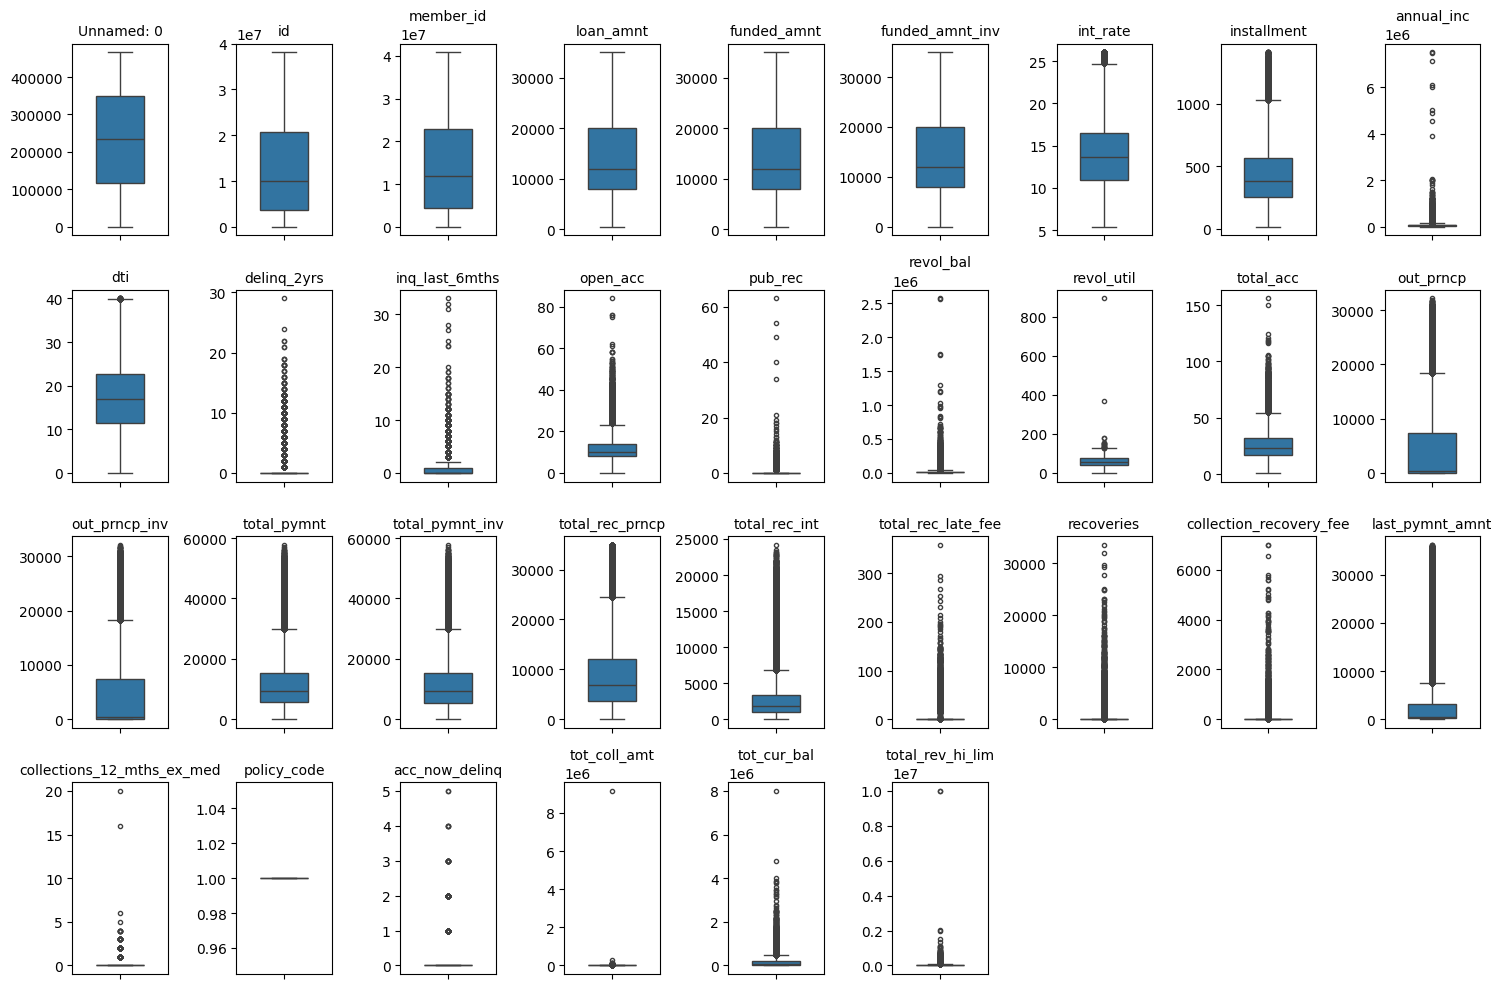

In [14]:
def check_outliers_box(target_col, data,  width=15, height=10):
    num_plots = len(target_col.columns)
    num_rows = (num_plots - 1) // 9 + 1

    plt.figure(figsize=(width, height))
    
    for i, col in enumerate(target_col.columns):
        plt.subplot(num_rows, 9, i+1)
        sns.boxplot(data[col], width=0.5, fliersize=3)
        plt.ylabel(None)
        plt.title(col, fontsize="medium")
        plt.tight_layout()

    plt.show()

# display the plot
check_outliers_box(numeric_without_miss, numeric)

##### 3.3. With KDE plot

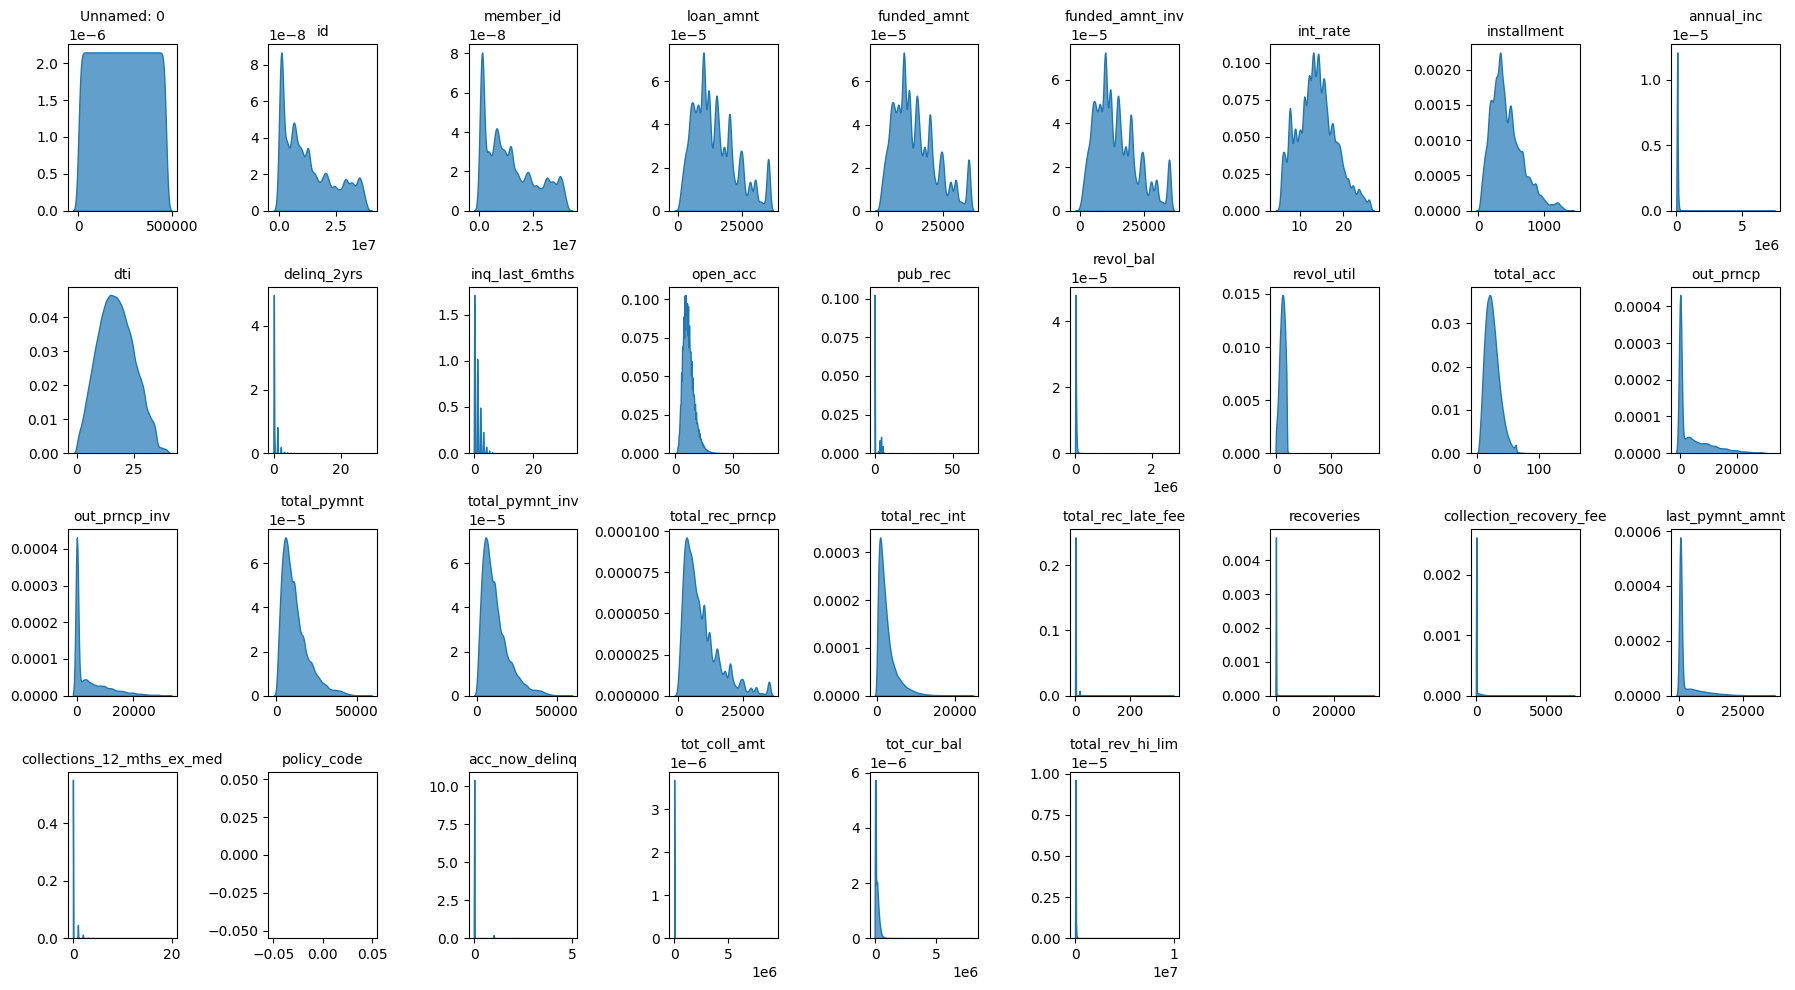

In [15]:
def check_outliers_kde(target_col, data, width=18, height=10):
    num_plots = len(target_col.columns)
    num_rows = (num_plots - 1) // 9 + 1

    plt.figure(figsize=(width, height))
    
    for i, col in enumerate(target_col.columns):
        plt.subplot(num_rows, 9, i+1)
        sns.kdeplot(data[col], fill=True, alpha=0.7)
        plt.title(col, fontsize="medium")
        plt.xlabel(None)
        plt.ylabel(None)
        plt.tight_layout()

    plt.show()

# display the plot 
check_outliers_kde(numeric_without_miss, numeric)

- Most of these numerical data distributions are positively skewed
- Columns with more than 40% missing values will be dropped
- Columns that have less than 40% missing values will be filled with median

##### 3.4. With Z-Score

In [16]:
# define a z-score function
def check_outliers_zscore(data, cols_name=None):
    outliers = []
    cols_name = data.columns

    for i, col in enumerate(data.columns):
        mean = np.mean(data[col])
        std = np.std(data[col])

        threshold = 3
        
        z_scores = [(x - mean)/std for x in data[col]]
        col_outliers = [i for i, z in enumerate(z_scores) if abs(z) > threshold]

        if len(col_outliers) > 0:
            outliers.append(cols_name[i])

    return outliers

In [17]:
# run check_outliers_zscore function
print(f"Total columns with outliers: {len(check_outliers_zscore(numeric_without_miss))} columns")
check_outliers_zscore(numeric_without_miss)

Total columns with outliers: 24 columns


['installment',
 'annual_inc',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim']

### Target Variable

Based on the purpose of creating this model, namely to predict credit risk, I will divide the loan_status column into two groups (good or bad loans). Where:
- Bad: Default, Charged Off, Late (31-120 days), Late (16-30 days), Does not meet the credit policy. Status:Charged Off, In Grace Period

- Good: Fully Paid, Current, Does not meet the credit policy. Status: Fully Paid

In [18]:
#Target variable: loan_status column
loan_status_copy = df["loan_status"].copy()

loan_status_copy.value_counts()

loan_status
Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

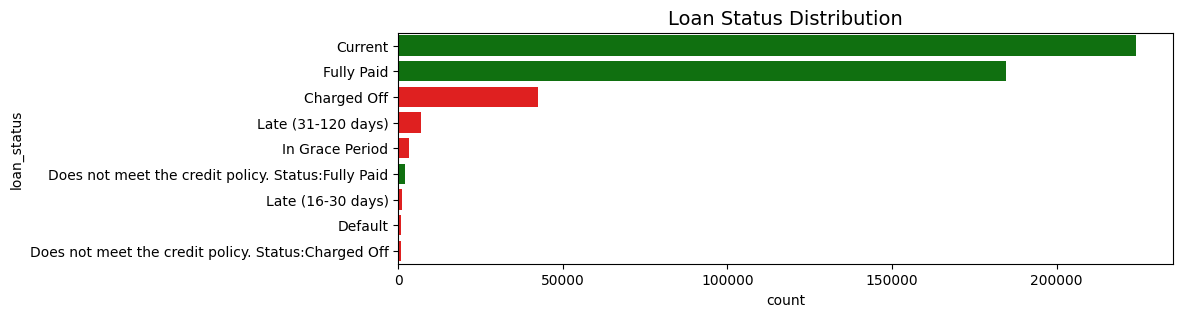

In [19]:
# visualize loan_status column distribution
order_loan = df["loan_status"].value_counts().sort_values(ascending=False).index

colors_gr = ["green" if status in ["Current", "Fully Paid", "Does not meet the credit policy. Status:Fully Paid"]
                            else "red" for status in order_loan]

plt.figure(figsize=(10, 3))

# Loan Status Distribution
sns.countplot(data=df, y="loan_status", order=order_loan, palette=colors_gr)
plt.title("Loan Status Distribution", fontsize=14)

plt.show()

In [20]:
# separate between good loans and bad loans
def good_bad_loan(status):
    return "Good Loan" if status in ["Current", "Fully Paid", "Does not meet the credit policy. Status:Fully Paid"] else "Bad Loan"

# apply the map good_bad_loan to loan_status column
df["loan_status"] = df["loan_status"].apply(good_bad_loan)

Loan status distribution:
loan_status
Good Loan    410953
Bad Loan      55332
Name: count, dtype: int64

Loan status distribution percentage:
Good Loan: 88.13%
Bad Loan: 11.87%

Assumed Total loss and profit:
Total profit: 5873258514.61
Total loss: 790793935.39


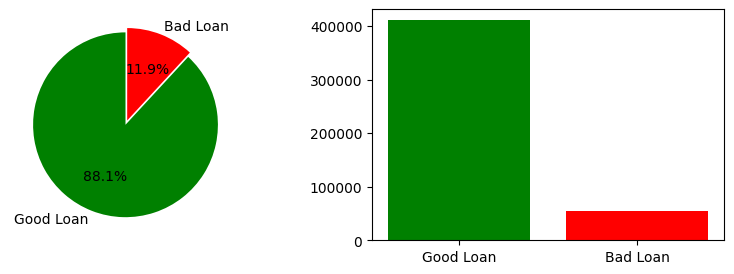

In [21]:
# create a a value counts of good loan and bad loan
cnt_good = df["loan_status"].value_counts()[0]
cnt_bad = df["loan_status"].value_counts()[1]

# create a good and bad loan percentage
total_loan = cnt_good + cnt_bad
loan_good_pct = (cnt_good / total_loan)*100
loan_bad_pct = (cnt_bad / total_loan)*100

# assume total loans to good loans as profit and otherwise
avg_loan_amount = df["funded_amnt"].mean()
total_profit = cnt_good*avg_loan_amount
total_loss = cnt_bad*avg_loan_amount

# print the result
print(f"Loan status distribution:\n{df["loan_status"].value_counts()}\n")
print(f"Loan status distribution percentage:\nGood Loan: {loan_good_pct:.2f}%\nBad Loan: {loan_bad_pct:.2f}%\n")
print(f"Assumed Total loss and profit:\nTotal profit: {total_profit:.2f}\nTotal loss: {total_loss:.2f}")

# create a value counts of loan_status and its index
loan_val = df["loan_status"].value_counts()
loan_val_label = loan_val.index

# create a pie chart
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.pie(loan_val, labels=loan_val_label,
        autopct="%1.1f%%", 
        startangle=90, colors=["g", "r"],
        explode=[0., 0.05])

# create a bar plot
plt.subplot(1, 2, 2)
plt.bar(loan_val_label, loan_val, color=["g", "r"])

plt.show()

- Based on the value distribution of the loan_status column, there is an imbalance between the value of Good Loan of **88.13%** and Bad Loan of **11.87%**.

- The total loans included in the Good Loan category are **$5,873,258,514** while for Bad Loan is **$790,793,935**.


### Plotting Function

#### 1. Define Line Plot

In [22]:
def add_lineplot(data, x, y, palette=None, hue=None, ci=95):
    sns.lineplot(data=data, x=x, y=y, palette=palette, hue=hue, ci=ci)

    # add some informations
    plt.title(f"{hue.replace("_", " ").title()} {y.replace("_", " ").title()} by {x.replace("_", " ").title()}", fontsize="large")
    plt.xlabel(f"{x.replace("_", " ").title()}")
    plt.ylabel(f"{y.replace("_", " ").title()}")
    plt.legend(title=hue.replace("_", " ").title(), fontsize="small", bbox_to_anchor=(1.02, 1), loc="upper left")

#### 2. Define Bar Plot

In [23]:
def add_barplot(data, x, y, palette=None, hue=None, order=None):
    sns.barplot(data=data, x=x, y=y, palette=palette, hue=hue, order=order)
    
    # add some informations
    plt.title(f"{y.replace("_", " ").title()} by {x.replace("_", " ").title()}", fontsize="large")
    plt.xlabel(f"{x.replace("_", " ").title()}")
    plt.ylabel(f"{y.replace("_", " ").title()}")

#### 3. Define Stacked Bar Plot

In [24]:
def add_st_barplot(data, x, y, palette=None, order=None):
    # calculate the value of loan status by region
    status_dis = data.groupby(x)[y].value_counts().unstack()
    status_dis = status_dis.reindex(order)

    # convert to percentage
    total_dis = status_dis.sum(axis=1)
    total_dis_pct = status_dis.apply(lambda i: i / total_dis * 100, axis=0)

    # Create the Good Loan and Bad Loan input
    bar1 = plt.bar(total_dis_pct.index,
                    total_dis_pct["Good Loan"],
                    label="Good Loan",
                    color=palette[0])
    bar2 = plt.bar(total_dis_pct.index,
                    total_dis_pct["Bad Loan"],
                    label="Bad Loan",
                    color=palette[1],
                    bottom=total_dis_pct["Good Loan"])

    # Add percentage annotations
    for bar1, bar2 in zip(bar1, bar2):
        percentage1 = bar1.get_height()
        percentage2 = bar2.get_height()

        plt.text(bar1.get_x() + bar1.get_width() / 2,
                 percentage1 / 2,
                 f"{percentage1:.2f}%",
                 color="w",
                 ha="center",
                 va="center",)

        plt.text(bar2.get_x() + bar2.get_width() / 2,
                 percentage1 + percentage2 / 2,
                 f"{percentage2:.2f}%",
                 color="w",
                 ha="center",
                 va="center",)

    # add some informations
    plt.title(f"Default Rate by {x.replace("_", " ").title()}",  fontsize="large")
    plt.xlabel(f"{x.replace("_", " ").title()}")
    plt.ylabel("Total Clients (%)")
    plt.legend(title=y.replace("_", " ").title(),  fontsize="small",  bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.grid(None)

#### 4. Define Pie Plot

In [25]:
def add_pieplot(data, label, palette=None, threshold=1):
    label_counts = data[label].value_counts()
    
    _, _, text = plt.pie(label_counts,
                         labels=label_counts.index,
                         colors=palette,
                         autopct=lambda p: f"{p:.2f}%" if p >= threshold else "",
                         startangle=90)

    # Set the color percentage to white
    for t in text:
        t.set_color("white")

    # add some informations
    plt.title(f"Distribution of {label.replace("_", " ").title()}", fontsize="large")
    plt.axis("equal")

### Analysis

#### 1. Analysis by Loan Year

##### Create Years Column

In [26]:
# change issue_d column to date format (month and year)
df["issue_d"] = pd.to_datetime(df["issue_d"], format="%b-%y")

# create years columns from issue_d
df["years"] = df["issue_d"].dt.year

##### Visualize

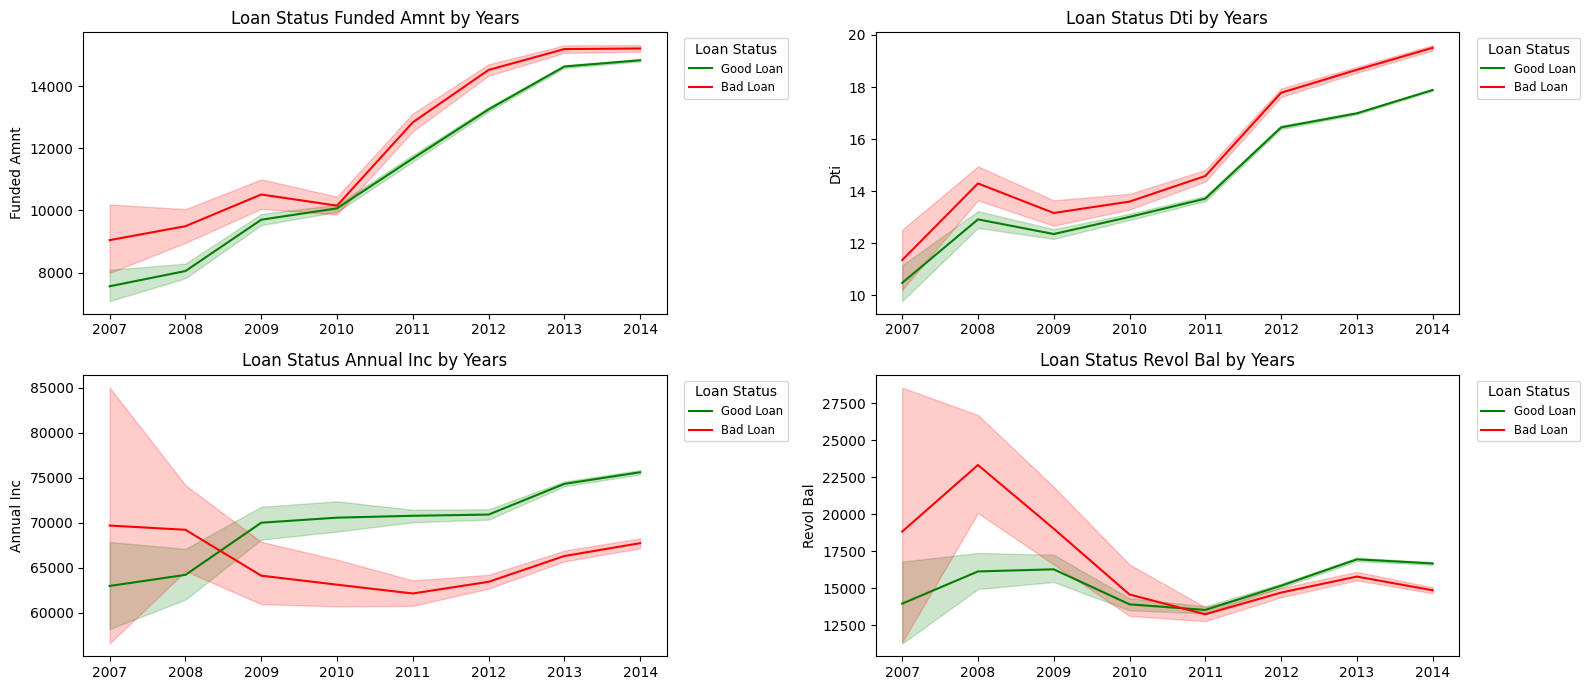

In [27]:
# visualize loan year analysis
plt.figure(figsize=(16, 7))

# Funded amount by loan status (in years)
plt.subplot(2, 2, 1)
add_lineplot(data=df, x="years", y="funded_amnt", palette=["g", "r"], hue="loan_status")
plt.xlabel(None)

# DTI by loan status (in years)
plt.subplot(2, 2, 2)
add_lineplot(data=df, x="years", y="dti", palette=["g", "r"], hue="loan_status")
plt.xlabel(None)

# Annual Income by loan status (in years)
plt.subplot(2, 2, 3)
add_lineplot(data=df, x="years", y="annual_inc", palette=["g", "r"], hue="loan_status")
plt.xlabel(None)

# Revolving balance by loan status (in years)
plt.subplot(2, 2, 4)
add_lineplot(data=df, x="years", y="revol_bal", palette=["g", "r"], hue="loan_status")
plt.xlabel(None)

plt.tight_layout()
plt.show()

##### Insight

- Funded amount by loan status (in years)
    - The number of loans given has increased every year
    - Overall, the number of loans with Good Loan status is smaller than Bad Loan status
    - Around 2009 there was a small decrease in Bad Loan until the following year. And starting in 2010 Bad Loan experienced a significant increase
    - In 2013 and subsequent years, Good Loan and Bad Loan approached the same value, and stagnated at the same time
    - This data indicates that the number of loans is increasing over time

- DTI by loan status (in years)
    - DTI (Debt to Income) continues to increase over time
    - There was a simultaneous decrease of Good Loan and Bad Loan in 2008, but it increased again for the following years
    - Interestingly, there is a similar pattern between Good Loan and Bad Loan when experiencing a decrease and increase

- Annual Income by loan status (in years)
    - There is a unique phenomenon here, the annual income from Good Loan is initially lower than Bad Loan, but over time it has increased quite consistently
    - The opposite happened with Bad Loan, there was a big decline over time, and started to see a slight increase starting in 2011
    - Annual income from Good Loan and Bad Loan were at the same value in mid-2008

- Revolving balance by loan status (in years)
    - In 2008 there was a significant decrease in revolving balance, this seems to be related to annual income and debt to income which decreased at the same time.
    - This could indicate that they are trying to reduce their financial burden and improve their financial stability, or it could be a sign that borrowers want to reduce reliance on revolving credit.

#### 2. Analysis by Region

##### Create Regions Column

In [28]:
print(f"Region list:\n{df["addr_state"].unique()}")
print(f"\nI will group the names of regions based on their abbreviations. These regions will be divided by region within the US state.")

Region list:
['AZ' 'GA' 'IL' 'CA' 'OR' 'NC' 'TX' 'VA' 'MO' 'CT' 'UT' 'FL' 'NY' 'PA'
 'MN' 'NJ' 'KY' 'OH' 'SC' 'RI' 'LA' 'MA' 'WA' 'WI' 'AL' 'CO' 'KS' 'NV'
 'AK' 'MD' 'WV' 'VT' 'MI' 'DC' 'SD' 'NH' 'AR' 'NM' 'MT' 'HI' 'WY' 'OK'
 'DE' 'MS' 'TN' 'IA' 'NE' 'ID' 'IN' 'ME']

I will group the names of regions based on their abbreviations. These regions will be divided by region within the US state.


In [29]:
West = ["CA", "NV", "UT", "CO", "WY", "MT", "ID", "OR", "WA", "AK", "HI"]

Southwest = ["AZ", "NM", "TX", "OK"]

Midwest = ["ND", "MN", "SD", "NE", "KS", "MO", "IA", "WI", "IL", "IN", "OH", "MI"]
 
Southeast = ["AR", "LA", "MS", "AL", "GA", "TN", "KY", "NC", "SC", "WV", "DC", "VA", "DE", "FL"]

Northeast = ["PA", "MD", "NJ", "NY", "CT", "RI", "MA", "NH", "VT", "ME"]

In [30]:
def us_region(state):
    if state in West:
        return "West"

    elif state in Southwest:
        return "Southwest"

    elif state in Midwest:
        return "Midwest"

    elif state in Southeast:
        return "Southeast"

    elif state in Northeast:
        return "Northeast"

    else:
        return "Other"

# Apply the function us_region to "addr_state" column
df["region"] = df["addr_state"].apply(us_region)

##### Visualize

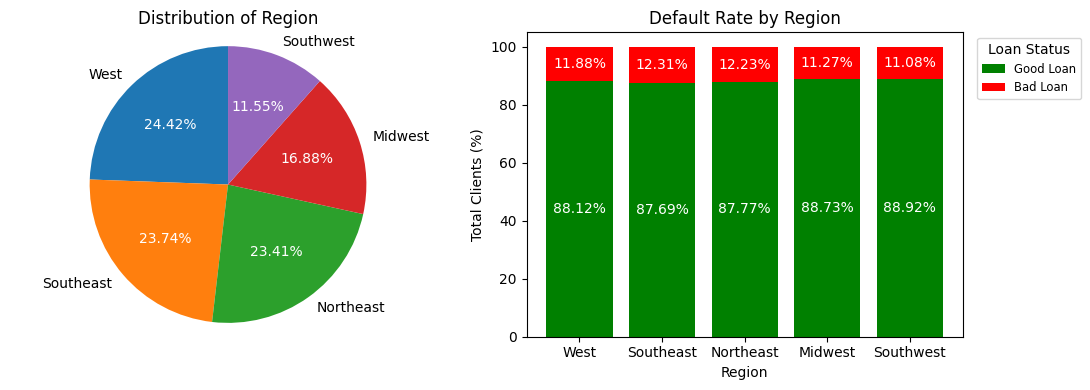

In [31]:
region_order = df["region"].value_counts().index

# visualize regions column analysis
plt.figure(figsize=(11, 4))

# pie plot distribution of region
plt.subplot(1, 2, 1)
add_pieplot(df, "region")

# stacked barplot default rate by region
plt.subplot(1, 2, 2)
add_st_barplot(df, "region", "loan_status", order=region_order, palette=["g", "r"])
plt.grid(None)

plt.tight_layout()
plt.show()

##### Insight

- Distribution of Region
    - The largest number of loans are in the west, southeast, and northeast regions
    - While the smallest number of loans is in the southwest region with a difference of twice that of the west region

- Default Rate by Region
    - There is no significant difference in default rates between regions
    - The region with the largest default rate is the southeast region, while the smallest is in the southwest region

#### 3. Analysis by State

##### Visualize

addr_state
CA    71450
NY    40242
TX    36439
FL    31637
IL    18612
Name: count, dtype: int64


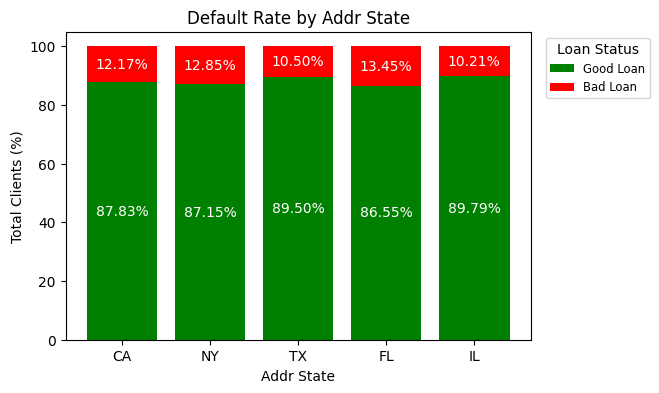

In [32]:
# select the top 5 state
top_states = df.addr_state.value_counts().head(5).index

# get the number of each state
print(df.addr_state.value_counts().head(5))

# visualize analysis by state
plt.figure(figsize=(6, 4))

add_st_barplot(df, "addr_state", "loan_status", order=top_states, palette=["g", "r"])
plt.grid(None)

plt.show()

##### Insight

- Top Clients with a loan value of **71,450** are from the state of CA (California) with a default rate of 12.17%
- Clients with a highest good loan value are from the state of IL (Illinois) with **89.79%**
- Clients with the highest default rate is the state of Fl (Florida) with **13.45%**

#### 4. Analysis of Loan Purpose

##### Visualize

purpose
debt_consolidation    274195
credit_card           104157
home_improvement       26537
other                  23690
major_purchase          9828
Name: count, dtype: int64


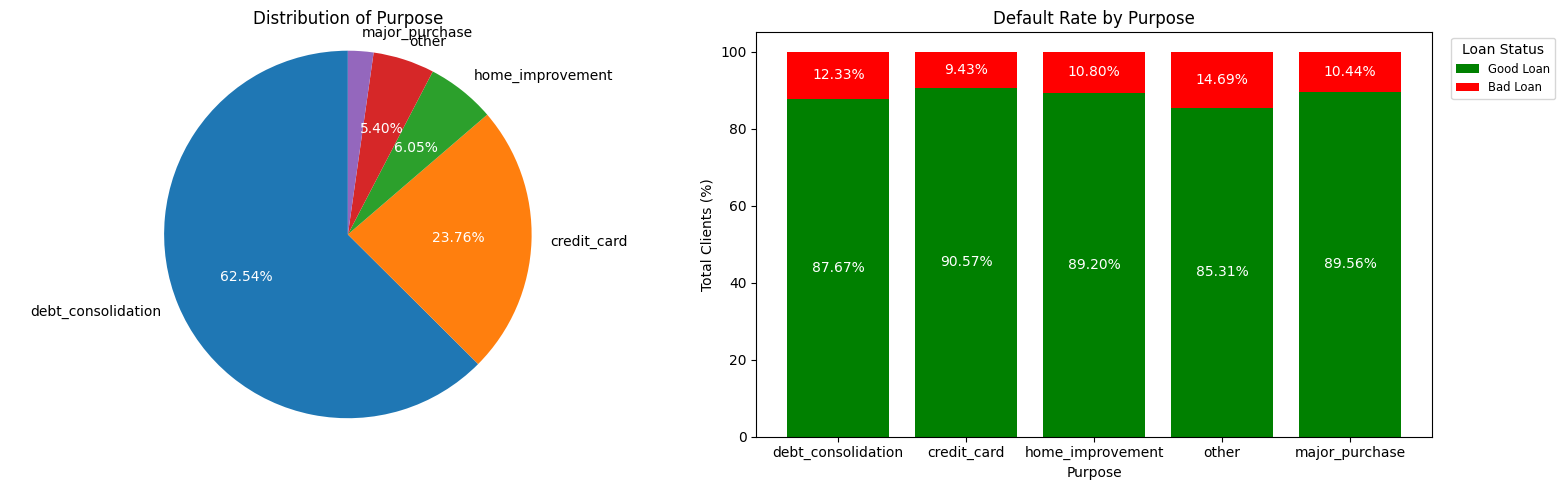

In [33]:
# get the number of top purpose
print(df["purpose"].value_counts().head(5))

# get top 5 purpose
top_pvalue = df["purpose"].value_counts().head(5).index
top_purpose = df[df["purpose"].isin(top_pvalue)]
purpose_order = top_purpose["purpose"].value_counts().index

# visualize loan purpose analysis
plt.figure(figsize=(16, 5))

# pie plot distribution of purpose
plt.subplot(1, 2, 1)
add_pieplot(top_purpose, "purpose", threshold=4)

# stacked barplot default rate by purpose
plt.subplot(1, 2, 2)
add_st_barplot(top_purpose, "purpose", "loan_status", order=purpose_order, palette=["g", "r"])
plt.grid(None)

plt.tight_layout()
plt.show()

##### Insight

- The top 5 loan purpose are debt consolidation, credit card, home improvement, other, and major purchase
- Debt consolidation dominated most of the total loans with **62.54%**
- Purpose with a highest good loan value is credit_card with **9.43%**
- Purpose with the highest default rate are from other with **14.69%**

#### 5. Analysis of Loan Grade

##### Visualize

Grade list:
['A' 'B' 'C' 'D' 'E' 'F' 'G']

Grade value counts:
grade
B    136929
C    125293
D     76888
A     74867
E     35757
F     13229
G      3322
Name: count, dtype: int64


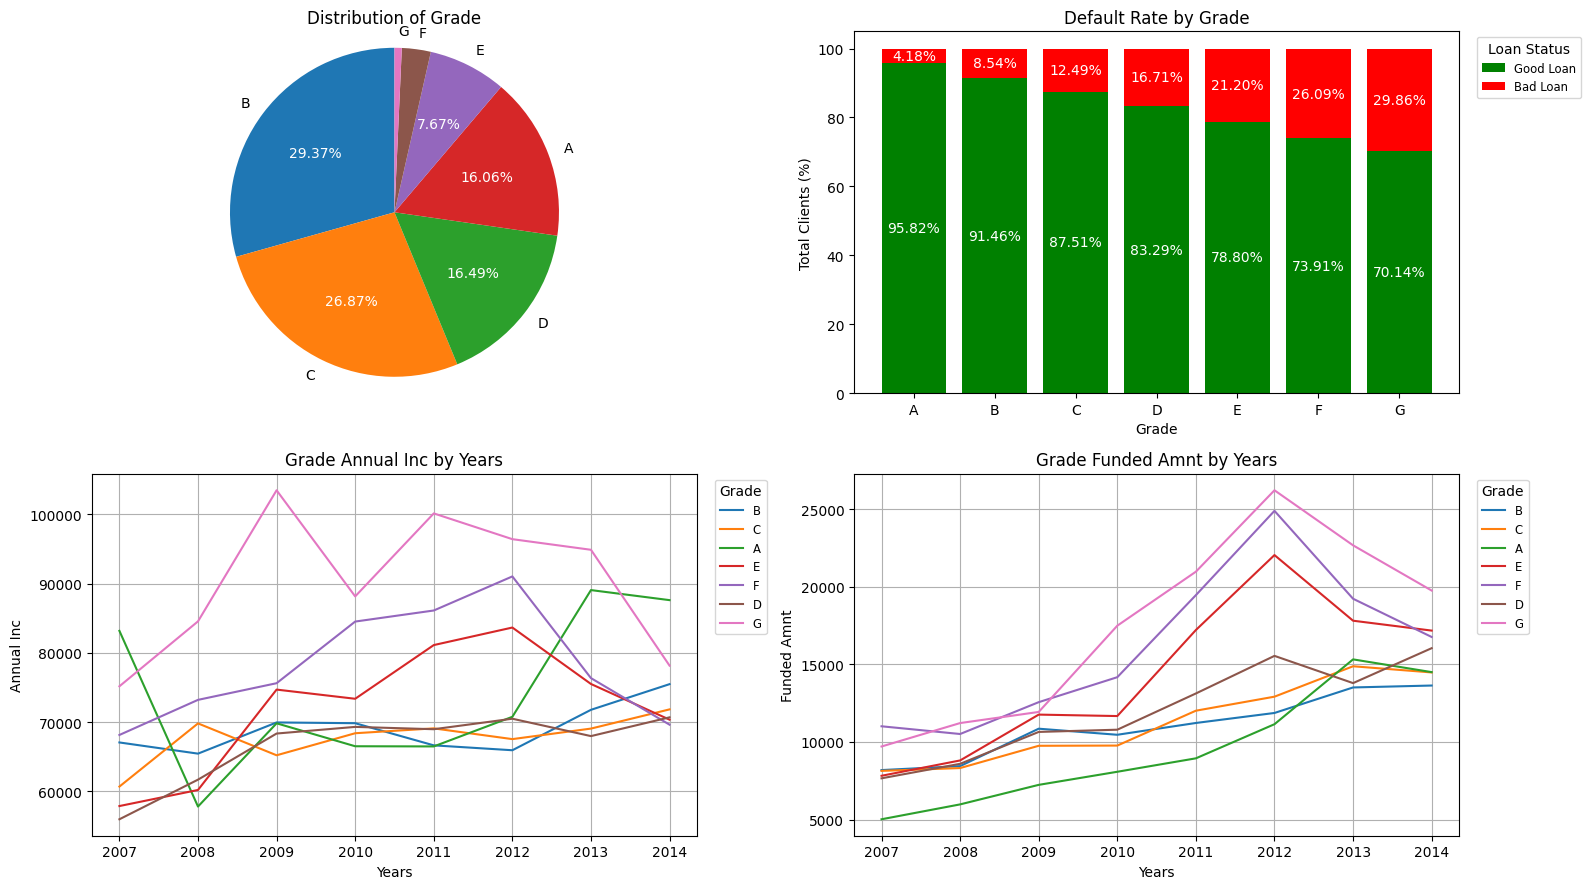

In [34]:
# print value of grade column
print(f"Grade list:\n{df["grade"].sort_values().unique()}\n")
print(f"Grade value counts:\n{df["grade"].value_counts()}")

# visualize loan grade analysis
plt.figure(figsize=(16, 9))

# sort grade values
grade_order = df["grade"].sort_values()

# pie plot distribution of grade
plt.subplot(2, 2, 1)
add_pieplot(df, "grade", threshold=7)

# stacked barplot default rate by grade
plt.subplot(2, 2, 2)
add_st_barplot(df, "grade", "loan_status", palette=["g", "r"])
plt.grid(None)

# line plot of grade annual income by years
plt.subplot(2, 2, 3)
add_lineplot(data=df, x="years", y="annual_inc", hue="grade", ci=None)
plt.grid(None)

# line plot of grade loan amount by years
plt.subplot(2, 2, 4)
add_lineplot(data=df, x="years", y="funded_amnt", hue="grade", ci=None)
plt.grid(None)

plt.tight_layout()
plt.show()

##### Insight

- Based on the grade column distribution, most of the grade clients are B and C grades
- The smaller the grade, the greater the default rate
- Clients grade that make the most loans are clients grade G
- On the other hand, A grade clients with the lowest default rate have a much smaller number of loans
- In the early years, grade G clients had the largest annual income, but starting in 2013, grade A clients began to overtake grade G clients in annual income
- Based on this pattern, the higher the annual income, the larger the loan amount
- Indicates that clients with large annual income are more likely to have large loans, but this is followed by a higher default rate

## 4. Data Preprocessing

### Dealing With Data

#### 1. Drop Columns - Missing Values

In [35]:
# drop the columns with >40% missing values
df_no_miss1 = drop_null(df, 40)

# output
print(f"Before:\n{df.shape}\n")
print(f"After:\n{df_no_miss1.shape}\n")

# checking for missing values
check_missing(df_no_miss1, ">", 0)

Before:
(466285, 77)

After:
(466285, 55)

df_no_miss1 columns with missing values:
tot_coll_amt (15.07%)
tot_cur_bal (15.07%)
total_rev_hi_lim (15.07%)
emp_title (5.92%)
emp_length (4.51%)
last_pymnt_d (0.08%)
revol_util (0.07%)
collections_12_mths_ex_med (0.03%)
last_credit_pull_d (0.01%)
delinq_2yrs (0.01%)
earliest_cr_line (0.01%)
inq_last_6mths (0.01%)
open_acc (0.01%)
pub_rec (0.01%)
total_acc (0.01%)
acc_now_delinq (0.01%)
title (0.00%)
annual_inc (0.00%)

Total columns with missing values is 18 columns
Total columns with >0% missing values is 18 columns


#### 2. Impute Columns - Missing Values

In [36]:
def fill_null(data):
    for column in data.columns:

        if data[column].dtype in ['int64', 'float64']:
            # fill with median if the data is number
            data[column] = data[column].fillna(data[column].median())
        else:
            # fill with mode if the data is object
            data[column] = data[column].fillna(data[column].mode()[0])
    return data

In [37]:
# fill the rest of missing values
df_no_miss2 = fill_null(df_no_miss1)

# checking for missing values
check_missing(df_no_miss2, ">", 0)

df_no_miss1 columns with missing values:

Total columns with missing values is 0 columns
Total columns with >0% missing values is 0 columns


#### 3. Drop Unnecessary Columns

In [38]:
unnecessary_col = [
    'application_type',
    'url',
    'zip_code',
    'collections_12_mths_ex_med',
    'out_prncp',
    'id',
    'total_pymnt_inv',
    'title', 'out_prncp_inv',
    'member_id',
    'Unnamed: 0',
    'total_rec_prncp',
    'total_rec_late_fee',
    'years',
    'addr_state',
    'policy_code',
    'acc_now_delinq',
    'emp_title',
    'recoveries', 
    'pymnt_plan',
    'collection_recovery_fee',
    'total_acc', 
    'sub_grade'
    ]

df_clean = df_no_miss2.drop(columns=unnecessary_col, axis=1)

#### 4. Train Test Split

In [39]:
X = df_clean.drop(columns=['loan_status'])
y = df_clean[['loan_status']]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=430)

print(f'train_X shape: {train_X.shape}')
print(f'train_y shape: {train_y.shape}\n')

print(f'test_X shape: {test_X.shape}')
print(f'test_y shape: {test_y.shape}')

train_X shape: (373028, 31)
train_y shape: (373028, 1)

test_X shape: (93257, 31)
test_y shape: (93257, 1)


### Feature Selection

#### 1. Chi-Square Test (Categorical)

In [40]:
# select categorical columns only
category_cols = train_X.select_dtypes('object')

# chi square test
chi_cols = []
for column in category_cols.columns:
    contingency_table = pd.crosstab(train_X[column], train_y['loan_status'])
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    
    dependency = 'Dependent' if p < 0.05 else 'Independent'
    chi_cols.append((column, chi2, p, dof, dependency))

# create dataframe from chi_cols
chi_results = pd.DataFrame(chi_cols, columns=['Feature', 'Chi2_Score', 'p_Value', 'DOF', 'Dependency'])
chi_results = chi_results.sort_values('p_Value')

chi_results

,Feature,Chi2_Score,p_Value,DOF,Dependency
0,term,1686.547694,0.000000e+00,1,Dependent
1,grade,11118.118015,0.000000e+00,6,Dependent
8,last_pymnt_d,35717.129330,0.000000e+00,97,Dependent
9,last_credit_pull_d,11960.365682,0.000000e+00,100,Dependent
5,purpose,1471.494398,6.026895e-307,13,Dependent
4,verification_status,824.137515,1.098532e-179,2,Dependent
3,home_ownership,780.474372,1.937174e-166,5,Dependent
7,initial_list_status,673.308751,1.905692e-148,1,Dependent
6,earliest_cr_line,1224.078963,3.099333e-37,653,Dependent
2,emp_length,89.613051,6.390700e-15,10,Dependent


- Column with highest significance:
    - `last_pymnt_d`: The last payment date has a significant impact on the loan status
    - `last_credit_pull_d`: The date of the last credit withdrawal has a significant influence on the loan status

- Column with lowest significance:
    - `region`: Even though this p-value is higher compared to the other columns, it still shows a significant relationship between region and loan status
    - `emp_length`: Length of work period has a significant influence on loan status

#### 2. Anova Test (Numerical)

##### Drop columns - Muticollinearity

<Axes: >

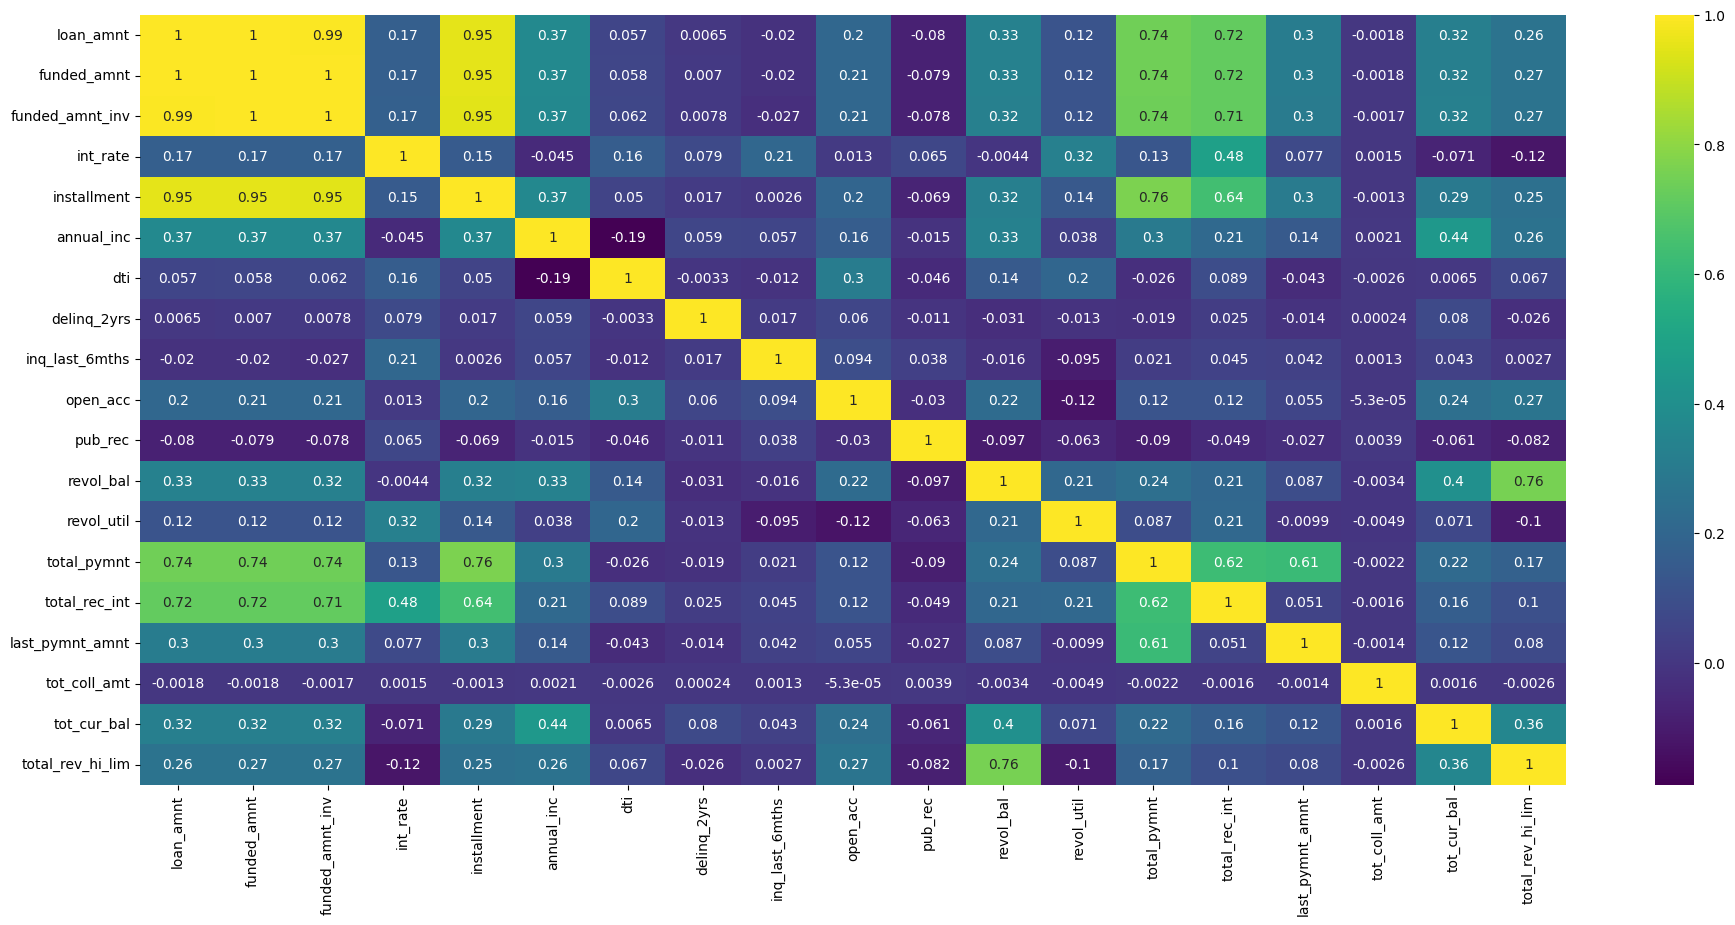

In [41]:
# select numerical columns only
numeric_cols = train_X.select_dtypes('number')

# correlation matrix
num_corr = numeric_cols.corr()

plt.figure(figsize=(23, 10))
sns.heatmap(num_corr, cmap='viridis', annot=True)


In [42]:
# drop multicollinearity columns
multi_cols = ['loan_amnt', 'funded_amnt_inv', 'installment', 'total_pymnt', 'total_rec_int', 'revol_bal']

train_X_nomulti = train_X.drop(columns=multi_cols, axis=1)

##### Anova Test

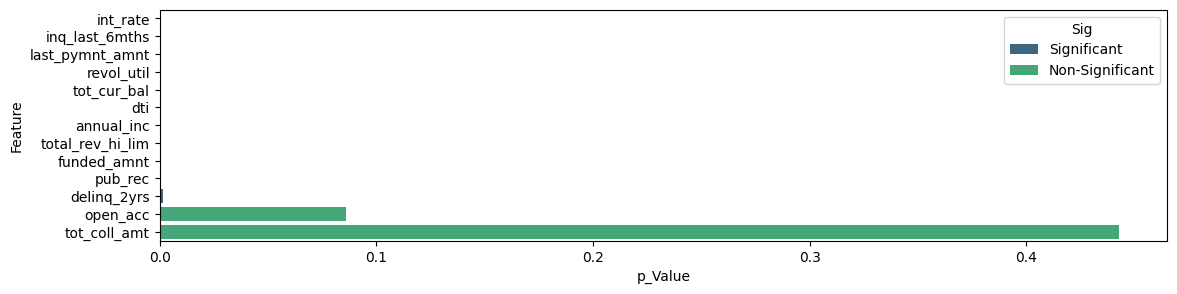

In [43]:
# select latest numerical columns only
new_numerical_cols = train_X_nomulti.select_dtypes('number')

# anova test
anova_cols = []
for i, column in enumerate(new_numerical_cols.columns):
    good_loan = tuple(train_X_nomulti[column][train_y['loan_status'] == 'Good Loan'])
    bad_loan = tuple(train_X_nomulti[column][train_y['loan_status'] == 'Bad Loan'])

    f_statistic, p_value = f_oneway(good_loan, bad_loan)

    sig = 'Significant' if p_value < 0.05 else 'Non-Significant'
    anova_cols.append((column, f_statistic, p_value, sig))
    
# create dataframe from anova_cols
anova_results = pd.DataFrame(anova_cols, columns=['Feature', 'f_Score', 'p_Value', 'Sig'])
anova_results = anova_results.sort_values('p_Value')

plt.figure(figsize=(13, 3))
sns.barplot(data=anova_results, x='p_Value', y='Feature', hue='Sig', palette='viridis')
plt.show()

In [44]:
# drop non-significant columns
non_sig = ['tot_coll_amt']

# drop the non-significant columns
train_X_sig = train_X_nomulti.drop(columns=non_sig, axis=1)

print(train_X_sig.columns)

Index(['funded_amnt', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_util', 'initial_list_status',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'tot_cur_bal',
       'total_rev_hi_lim', 'region'],
      dtype='object')


#### 3. Cap Outlier

In [45]:
def cap_outliers(data, cols):
    for column in cols:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap the outliers
        data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), 
                                np.clip(data[column], lower_bound, upper_bound),
                                data[column])

    return data

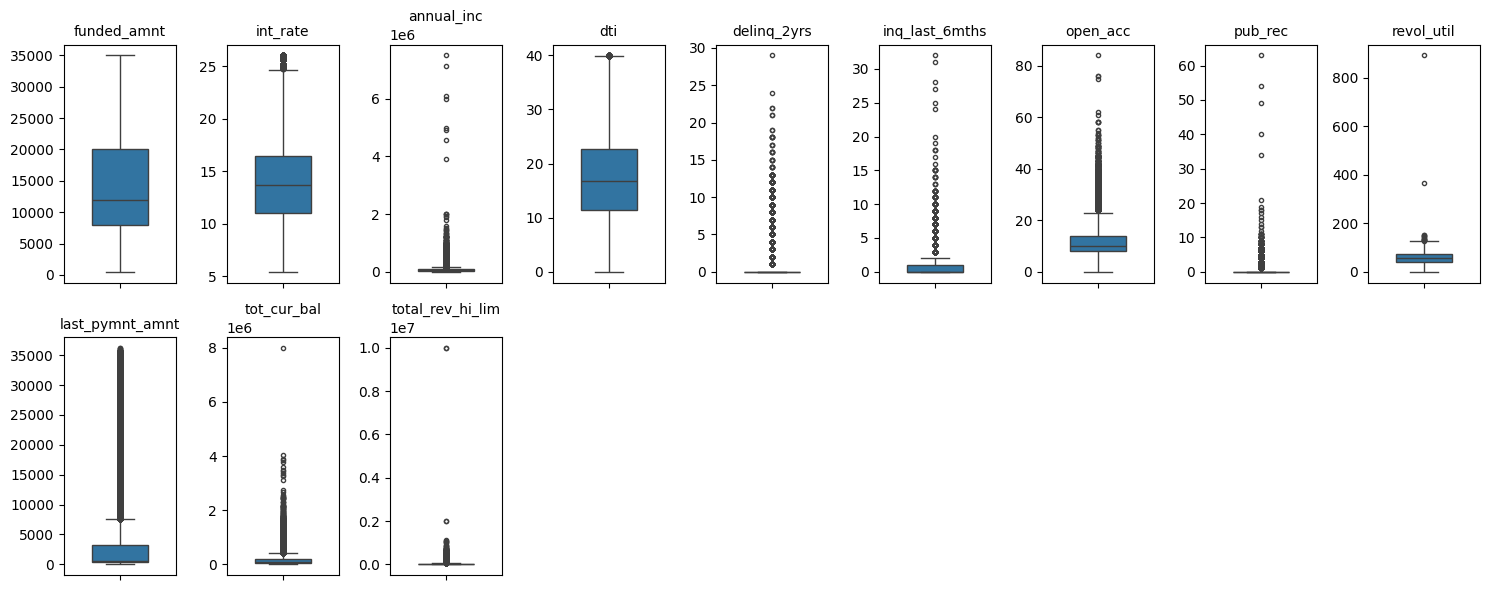

In [46]:
# select latest numerical columns only
sig_numerical_cols = train_X_sig.select_dtypes('number')

# checking for outliers
check_outliers_box(sig_numerical_cols, train_X_sig, 15, 6)

In [47]:
outliers = ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'tot_cur_bal', 'total_rev_hi_lim']

train_X_noutlier = cap_outliers(train_X_sig, outliers)

train_X_noutlier.head(3)

,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,...,open_acc,pub_rec,revol_util,initial_list_status,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,tot_cur_bal,total_rev_hi_lim,region
961,5000,36 months,16.29,D,10+ years,OWN,40000.00,Not Verified,2011-12-01,car,...,9.0,0.0,92.2,f,Feb-15,9.33,Jan-16,81539.0,22800.0,Northeast
63138,4000,36 months,17.76,D,10+ years,MORTGAGE,40724.69,Verified,2013-11-01,debt_consolidation,...,17.0,0.0,33.3,f,Dec-15,144.13,Jan-16,196888.0,31100.0,Midwest
173067,15000,36 months,17.27,C,2 years,RENT,50000.00,Verified,2013-01-01,debt_consolidation,...,6.0,0.0,74.8,f,Jul-15,425.74,Jan-16,35879.0,16330.0,Midwest


### Feature Engineering

#### Convert Date Columns to Number

In [48]:
train_X_temp = train_X_noutlier.copy()

# define a function to split days dan months
def days_month_converter(data, cols):
    data[cols] = pd.to_datetime(data[cols], format='%b-%y')
    current_date = pd.to_datetime('today').normalize()

    # iterate for create new columns
    data[f"days_since_{cols}"] = (current_date - data[cols]).dt.days
    data[f"{cols}_month"] = data[cols].dt.month
    data = data.drop(columns=cols, axis=1)

    return data

# list of date columns
dates = ['issue_d', 'earliest_cr_line', 'last_credit_pull_d', 'last_pymnt_d']

# convert the date columns
for date in dates:
   train_X_temp = days_month_converter(train_X_temp, date)

# merge none and any with other
modify_home = {'NONE': 'OTHER', 'ANY': 'OTHER'}

train_X_temp['home_ownership'] = train_X_temp['home_ownership'].replace(modify_home)

#### Encoding (One-Hot Encoding)

One hot encoding is used to convert categorical variables into binary representations that can be used in analysis or models.

In [49]:
train_X_encoding = train_X_temp.copy()

# columns to be one-hot encoded
ohe_cols = train_X_encoding.select_dtypes('object').columns

# perform one-hot encoding on each column
for column in ohe_cols:
    dummies = pd.get_dummies(train_X_encoding[column], prefix=f'{column}:').astype(int)

    dummies.columns = [re.sub(r'[<>":\s]', '', col) for col in dummies.columns]
    dummies = dummies.groupby(dummies.columns, axis=1).agg('sum')

    train_X_encoding = pd.concat([train_X_encoding, dummies], axis=1)
    train_X_encoding.drop(columns=column, axis=1, inplace=True)

# define a map target "loan_status"
lstatus_map = {'Good Loan': 0, 'Bad Loan': 1}

train_y['loan_status'] = train_y['loan_status'].map(lstatus_map)

print(f"After one-hot encoding:\n{train_X_encoding.shape}")

After one-hot encoding:
(373028, 67)


#### Scaling (Standard Scaler)

Feature scaling is used to transform the scale or range of values of features in a dataset. It is important to ensure that all features have a similar or equivalent scale, so that no feature dominates or has an overly large influence on the analysis or model.

In [50]:
scaler = StandardScaler()

train_X_scaled = pd.DataFrame(scaler.fit_transform(train_X_encoding))

# reset column names and indexes
train_X_scaled.columns = train_X_encoding.columns
train_X_scaled.index = train_X_encoding.index

print(f"After scaling:\n{train_X_scaled.shape}")
train_X_scaled.sample(3)

After scaling:
(373028, 67)


,funded_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,last_pymnt_amnt,...,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,region_Midwest,region_Northeast,region_Southeast,region_Southwest,region_West
128959,0.258590,-1.131388,-0.969127,0.580374,0.0,0.319729,1.058140,0.0,-0.238039,1.362391,...,-0.123801,-0.074026,-0.070291,0.733978,-0.733978,2.219813,-0.552174,-0.557781,-0.361804,-0.569033
135463,-1.580836,-0.842073,0.087070,-1.352893,0.0,1.479341,-0.233431,0.0,-2.356906,-0.457329,...,-0.123801,-0.074026,-0.070291,0.733978,-0.733978,-0.450488,1.811024,-0.557781,-0.361804,-0.569033
259427,1.173773,0.404739,-0.007603,-0.534727,0.0,0.319729,2.564974,0.0,-0.031218,-0.458569,...,-0.123801,-0.074026,-0.070291,-1.362440,1.362440,-0.450488,-0.552174,1.792818,-0.361804,-0.569033


#### Resampling (SMOTE)

Modify the distribution of data by adjusting class proportions or generating synthetic data.

In [51]:
smote = SMOTE(random_state=430)

smote_train_X, smote_train_y = smote.fit_resample(train_X_scaled, train_y)

print(f"Before Resampled:\n{train_y.value_counts()}\n")
print(f"After Resampled:\n{smote_train_y.value_counts()}")

Before Resampled:
loan_status
0              328752
1               44276
Name: count, dtype: int64

After Resampled:
loan_status
0              328752
1              328752
Name: count, dtype: int64


#### Apply to Data Test

##### Apply to test_X

In [52]:
# 1. fill missing values
test_X_clean = fill_null(test_X)

# 2. drop multicollinearity columns
test_X_nomulti = test_X_clean.drop(columns=multi_cols, axis=1)

# 3. drop non-significant columns
test_X_sig = test_X_nomulti.drop(columns=non_sig, axis=1)

# 4. split days dan months
test_X_temp = test_X_sig.copy()

for date in dates:
   test_X_temp = days_month_converter(test_X_temp, date)

# 5. merge none and any with other
modify_home = {'NONE': 'OTHER', 'ANY': 'OTHER'}

test_X_temp['home_ownership'] = test_X_temp['home_ownership'].replace(modify_home)

# 6. encoding test_X
test_X_encoding = test_X_temp.copy()

# 7. one-hot encoding test_X
ohe_cols_test = test_X_encoding.select_dtypes('object').columns

for column in ohe_cols_test:
    dummies = pd.get_dummies(test_X_encoding[column], prefix=f'{column}:').astype(int)
    
    dummies.columns = [re.sub(r'[<>":\s]', '', col) for col in dummies.columns]
    dummies = dummies.groupby(dummies.columns, axis=1).agg('sum')

    test_X_encoding = pd.concat([test_X_encoding, dummies], axis=1)
    test_X_encoding.drop(columns=column, axis=1, inplace=True)

# 8. scaling test_X
test_X_scaled = pd.DataFrame(scaler.transform(test_X_encoding))

test_X_scaled.columns = test_X_encoding.columns
test_X_scaled.index = test_X_encoding.index

# 9. apply loan_status mapping
test_y['loan_status'] = test_y['loan_status'].map(lstatus_map)

# 10. results
print(test_X_scaled.shape)
display(test_X_scaled.sample(3))

(93257, 67)


,funded_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,last_pymnt_amnt,...,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,region_Midwest,region_Northeast,region_Southeast,region_Southwest,region_West
173831,-0.565980,0.452958,1.056198,0.673405,0.0,2.638954,0.197093,0.0,1.302571,0.318359,...,-0.123801,-0.074026,-0.070291,0.733978,-0.733978,-0.450488,1.811024,-0.557781,-0.361804,-0.569033
123817,-1.121735,1.529854,-0.140737,-0.004576,0.0,2.638954,-0.448693,1.0,-1.153964,-0.528994,...,-0.123801,-0.074026,-0.070291,-1.362440,1.362440,-0.450488,-0.552174,1.792818,-0.361804,-0.569033
364305,-0.276021,-1.540103,-0.895163,0.257950,0.0,2.638954,-0.233431,0.0,-0.824738,-0.495861,...,-0.123801,-0.074026,-0.070291,-1.362440,1.362440,-0.450488,-0.552174,-0.557781,2.763930,-0.569033


##### Apply to X and y for Cross Validation

In [53]:
# 1. fill missing values
X_clean = fill_null(X)

# 2. drop multicollinearity columns
X_nomulti = X_clean.drop(columns=multi_cols, axis=1)

# 3. drop non-significant columns
X_sig = X_nomulti.drop(columns=non_sig, axis=1)

# 4. split days dan months
X_temp = X_sig.copy()

for date in dates:
   X_temp = days_month_converter(X_temp, date)

# 5. merge none and any with other
modify_home = {'NONE': 'OTHER', 'ANY': 'OTHER'}

X_temp['home_ownership'] = X_temp['home_ownership'].replace(modify_home)

# 6. encoding x
X_encoding = X_temp.copy()

# 7. one-hot encoding x
ohe_cols_test = X_encoding.select_dtypes('object').columns

for column in ohe_cols_test:
    dummies = pd.get_dummies(X_encoding[column], prefix=f'{column}:').astype(int)

    dummies.columns = [re.sub(r'[<>":\s]', '', col) for col in dummies.columns]
    dummies = dummies.groupby(dummies.columns, axis=1).agg('sum')
    
    X_encoding = pd.concat([X_encoding, dummies], axis=1)
    X_encoding.drop(columns=column, axis=1, inplace=True)

# 8. scaling x
X_scaled = pd.DataFrame(scaler.fit_transform(X_encoding))

X_scaled.columns = X_encoding.columns
X_scaled.index = X_encoding.index

# 9. apply loan_status mapping
y['loan_status'] = y['loan_status'].map(lstatus_map)

# 10. results
print(X_scaled.shape)
display(X_scaled.sample(3))

(466285, 67)


,funded_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,last_pymnt_amnt,...,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,region_Midwest,region_Northeast,region_Southeast,region_Southwest,region_West
122204,1.656708,0.677156,0.122313,-0.872330,-0.357012,-0.737182,1.566557,-0.31429,1.606898,-0.383222,...,-0.123571,-0.073227,-0.071065,0.734077,-0.734077,2.219232,-0.552895,-0.557916,-0.361362,-0.568450
193134,-0.518687,0.339813,-0.787386,1.047144,0.897154,0.178920,0.965038,-0.31429,-0.079160,-0.499721,...,-0.123571,-0.073227,-0.071065,0.734077,-0.734077,2.219232,-0.552895,-0.557916,-0.361362,-0.568450
243829,-0.518687,-0.548294,-0.241567,1.359201,-0.357012,-0.737182,-0.037494,-0.31429,0.068370,-0.522849,...,-0.123571,-0.073227,-0.071065,-1.362255,1.362255,-0.450606,-0.552895,-0.557916,-0.361362,1.759168


## 5. Modeling

### Define Model Evaluation

In [54]:
def evaluate_model(model, train_X, test_X, train_y, test_y, threshold):
    
    # fit the model to train
    model.fit(train_X, train_y)

    # model predict
    test_pred = model.predict(test_X)

    # accuracy score
    test_accuracy = accuracy_score(test_y, test_pred)

    # roc auc score
    train_pred_proba = model.predict_proba(train_X)[:, 1]  
    test_pred_proba = model.predict_proba(test_X)[:, 1]

    train_auc = roc_auc_score(train_y, train_pred_proba)
    test_auc = roc_auc_score(test_y, test_pred_proba)

    # recall score
    train_recall = recall_score(train_y, train_pred_proba > threshold)
    test_recall = recall_score(test_y, test_pred_proba > threshold)

    # precision score
    train_precision = precision_score(train_y, train_pred_proba > threshold)
    test_precision = precision_score(test_y, test_pred_proba > threshold)

    # f1 score
    train_f1 = f1_score(train_y, train_pred_proba > threshold)
    test_f1 = f1_score(test_y, test_pred_proba > threshold)

    # perform cross validation
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=430)
    cv_score = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc')

    # gather all results
    score_all = {'Model': model.__class__.__name__,
                 'Accuracy': [test_accuracy], 
                 'AUC_train': [train_auc], 
                 'AUC_test': [test_auc],
                 'Recall_train': [train_recall],
                 'Recall_test': [test_recall],
                 'Precision_train': [train_precision],
                 'Precision_test': [test_precision],
                 'F1_train': [train_f1], 
                 'F1_test': [test_f1],
                 'CrossVal_AUC': [cv_score.mean()]}

    # convert to df
    df_evaluation = pd.DataFrame(score_all)
    
    return df_evaluation

### Define Plot Evalution

In [55]:
def add_roc_curve(model, train_X, test_X, train_y, test_y, ax):
    model.fit(train_X, train_y)

    # roc auc score
    y_pred_proba = model.predict_proba(test_X)[:, 1]
    fpr, tpr, _ = roc_curve(test_y, y_pred_proba)
    auc = roc_auc_score(test_y, y_pred_proba)

    # plot the results
    ax.plot(fpr, tpr, label=f'{model.__class__.__name__} AUC = {auc:.2f}')

### Train and Evaluate Model

In [56]:
# my models
models = [
LogisticRegression(random_state=430), 
LGBMClassifier(verbosity=-1, random_state=430), 
RandomForestClassifier(max_depth=7, random_state=430), 
XGBClassifier(n_estimators=300, learning_rate=0.2, max_depth=5, random_state=430), 
GaussianNB(priors=[0.6, 0.4], var_smoothing=1e-9)
]

,Model,Accuracy,AUC_train,AUC_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,CrossVal_AUC
1,LogisticRegression,0.872235,0.946215,0.936521,0.778395,0.757688,0.921704,0.606941,0.844009,0.673988,0.933416
2,LGBMClassifier,0.973525,0.997341,0.980540,0.972849,0.834569,0.993221,0.941339,0.982929,0.884744,0.979651
3,RandomForestClassifier,0.911567,0.980754,0.936825,0.847450,0.619844,0.973646,0.785354,0.906176,0.692852,0.947957
4,XGBClassifier,0.976452,0.998463,0.982425,0.977688,0.832941,0.996487,0.962077,0.986998,0.892864,0.982185
5,GaussianNB,0.804915,0.832696,0.811024,0.567449,0.527044,0.807877,0.346330,0.666648,0.417991,0.808304


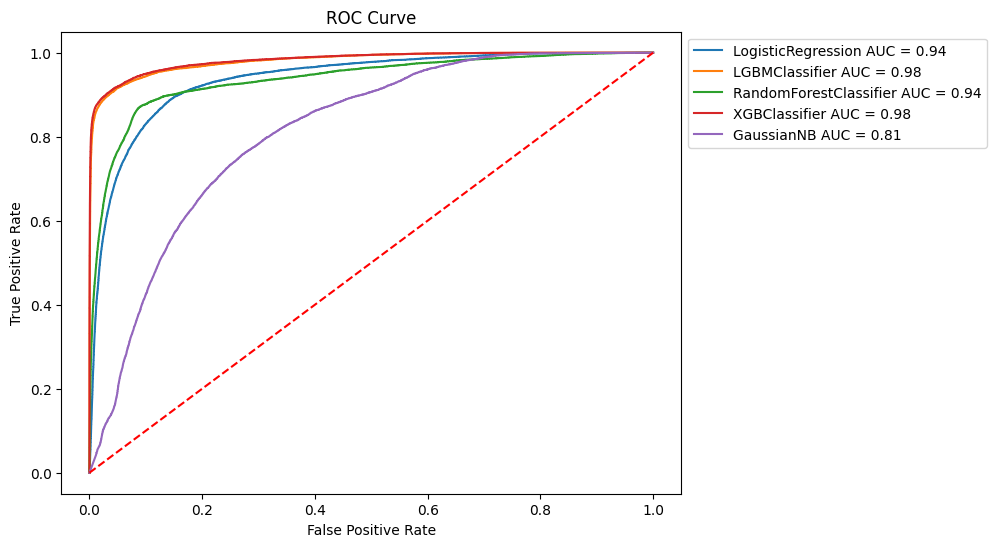

In [57]:
# evaluate the models
results = []

for model in models:
    result = evaluate_model(model, smote_train_X, test_X_scaled, smote_train_y, test_y, 0.7)
    results.append(result)

# display the models score
models_result = pd.concat(results).reset_index(drop=True)
models_result.index = models_result.index + 1
display(models_result)

# plot roc curve
fig, ax = plt.subplots(figsize=(8, 6))

for model in models:
    add_roc_curve(model, smote_train_X, test_X_scaled, smote_train_y, test_y, ax)

ax.plot([0, 1], [0, 1], 'r--')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")

plt.show()

- `Summary:`  
It can be seen from all the models run that we get one model with the best performance, namely `XGBClassifier`.

- `Accuracy:`     
The accuracy of the model is **0.976452**, which indicates that the model as a whole can correctly classify about **97.65%** of all samples.
- `AUC_train:`      
The AUC (Area Under the Curve) on the training data is **0.998463**, which indicates that the model has excellent ability to distinguish between positive and negative classes on the training data.
- `AUC_test:`     
The AUC on the test data is **0.982425**, which indicates that the model has good ability to distinguish between positive and negative classes on data that has not been seen before. This shows that the model is able to generalize well on new data.
- `Recall_train:`     
The recall on the training data is **0.977688**, which indicates that the model is able to identify approximately **97.77%** of all positive samples present in the training data.
- `Recall_test:`      
The recall on the test data is **0.832941**, which indicates that the model is able to identify approximately **83.29%** of all positive samples present in the test data.
- `Precision_train:`      
Precision on the training data is **0.996487**, which indicates that approximately **99.65%** of all positive predictions made by the model on the training data are correct.
- `Precision_test:`       
Precision on the test data is **0.962077**, which indicates that approximately **96.21%** of all positive predictions made by the model on the test data are correct.
- `CrossVal_AUC:`     
The AUC of cross-validation results is **0.982185**, which shows consistently good performance on different test data.

Problem:
- Lower recall on test data compared to train data can indicate overfitting, where the model is unable to effectively generalize to data that has never been seen before.
- Lower precision on the test data compared to the training data may indicate a problem with the number of false positive results produced by the model.

### Hyperparameter Tuning

In [60]:
model_selected = XGBClassifier(n_estimators=300, learning_rate=0.2, max_depth=5, random_state=430)
threshold_tun = [0.5, 0.55, 0.6]

results = []

for tun in threshold_tun:
    result = evaluate_model(model_selected, smote_train_X, test_X_scaled, smote_train_y, test_y, tun)
    results.append(result)

# display the models score
models_result = pd.concat(results).reset_index(drop=True)
models_result.index = models_result.index + 1
display(models_result)

,Model,Accuracy,AUC_train,AUC_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,CrossVal_AUC
1,XGBClassifier,0.976452,0.998463,0.982425,0.981780,0.857182,0.994264,0.938875,0.987982,0.896170,0.982185
2,XGBClassifier,0.976452,0.998463,0.982425,0.980949,0.851936,0.994876,0.945588,0.987863,0.896322,0.982185
3,XGBClassifier,0.976452,0.998463,0.982425,0.980064,0.847413,0.995455,0.951361,0.987700,0.896383,0.982185


From these experiments we get the most optimal threshold at **0.5**, this number is able to balance recall and precision better.

#### Further Tuning (skip)

In [58]:
# to find the most optimal parameters run the following code
# however i will not run this code due to device limitations and long processing times

'''
my_model = XGBClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5],
    'random_state': [430, 250, 850],
    'threshold': [0.5, 0.6, 0.7]
}

scorer = make_scorer(recall_score, greater_is_better=True)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=430)

grid_search = GridSearchCV(estimator=my_model, param_grid=param_grid, cv=cv, scoring=scorer)

grid_search.fit(smote_train_X, smote_train_y)

best_params = grid_search.best_params_
'''

"\nmy_model = XGBClassifier()\n\nparam_grid = {\n    'n_estimators': [100, 200, 300],\n    'learning_rate': [0.1, 0.2, 0.3],\n    'max_depth': [3, 4, 5],\n    'random_state': [430, 250, 850],\n    'threshold': [0.5, 0.6, 0.7]\n}\n\nscorer = make_scorer(recall_score, greater_is_better=True)\n\ncv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=430)\n\ngrid_search = GridSearchCV(estimator=my_model, param_grid=param_grid, cv=cv, scoring=scorer)\n\ngrid_search.fit(smote_train_X, smote_train_y)\n\nbest_params = grid_search.best_params_\n"

### Top Feature

In [61]:
best_model = XGBClassifier(n_estimators=300, learning_rate=0.2, max_depth=5, random_state=430)

best_model.fit(smote_train_X, smote_train_y)

feature_importances = best_model.feature_importances_

# get feature names and score
importance_df = pd.DataFrame({'Feature': smote_train_X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

print(importance_df.head(10))

                    Feature  Importance
21            term_60months    0.160700
9           last_pymnt_amnt    0.152830
18  days_since_last_pymnt_d    0.144020
5            inq_last_6mths    0.079346
22                  grade_A    0.058990
61    initial_list_status_w    0.045783
19       last_pymnt_d_month    0.044784
12       days_since_issue_d    0.041393
20            term_36months    0.037072
13            issue_d_month    0.029068


Top 3 features:
1. term_60months: This feature indicates the loan repayment amount in months.This feature can provide information about the duration of the loan and may affect the borrower's ability to repay the loan.

2. last_pymnt_amnt: This feature shows the amount of the last payment received. This feature provides information on how large the last payment made by the borrower is, which may reflect their ability to make payments consistently.

3. days_since_last_pymnt_d: This feature indicates the last month the payment was received. This feature provides information about the last time a payment was made, which can provide insight into the borrower's payment behavior.

### Confusion Matric

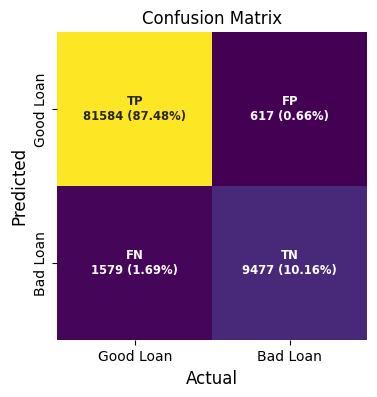

In [69]:
def plot_confusion_matrix(model, test_X, test_y, threshold):
    pred_y_proba = model.predict_proba(test_X)[:, 1]
    pred_y = (pred_y_proba > threshold).astype(int)

    cm = confusion_matrix(test_y, pred_y)
    cm_perc = cm / cm.sum()

    labels = np.array([['TP', 'FP'], ['FN', 'TN']])
    labels = np.array([f'{label}\n{value} ({percentage:.2%})' for label, value, percentage in zip(labels.flatten(), cm.flatten(), cm_perc.flatten())]).reshape(2, 2)

    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm, 
        annot=labels, 
        fmt='', 
        cbar=False, 
        cmap='viridis', 
        annot_kws={'size': 'small', 'weight': 'bold'}, 
        linecolor='black', 
        xticklabels=['Good Loan', 'Bad Loan'], 
        yticklabels=['Good Loan', 'Bad Loan']
    )
    plt.xticks(fontsize='medium')
    plt.yticks(fontsize='medium')
    plt.xlabel('Actual', fontsize='large')
    plt.ylabel('Predicted', fontsize='large')
    plt.title('Confusion Matrix')
    plt.show()

# plot the confusion matrix
plot_confusion_matrix(best_model, test_X_scaled, test_y, 0.5)

Based on these results, this model has a good performance in classifying “Good Loan” with a high True Positive Rate (TPR) of `87.48%`.

`True Positive (TP)`: The number of correctly predicted positive samples.       
`True Negative (TN)`: The number of negative samples that were correctly predicted.     
`False Positive (FP)`: The number of negative samples that were incorrectly predicted as positive.      
`False Negative (FN)`: The number of positive samples that were incorrectly predicted as negative.

## 6. Evaluation

in this section we will evaluate by calculating the comparison of data before and after modeling.

In [73]:
# confusion matrix results
tp = 81584 
fp = 617
fn = 1579
tn = 9477

# total before
total_clients = df.shape[0]
total_clients_X = test_X_scaled.shape[0]
total_good_before = df["loan_status"].value_counts()[0]
total_bad_before = df["loan_status"].value_counts()[1]
total_loan = df["funded_amnt"].sum()
avg_loan =  total_loan / df.shape[0]

# default rate before
dr_before_model = total_bad_before / total_clients

# default rate after
dr_after_model = (fp + fn) / total_clients_X

# decrease in default rate
dec_dr = dr_after_model - dr_before_model

# total bad loans after
total_bad_after = dr_after_model * total_clients

# decrease in bad loans
dec_bad_loans = total_bad_after - total_bad_before

# total revenue, default loss and net revenue before
tr_before = total_good_before * avg_loan
total_dl_before = total_bad_before * avg_loan
net_rev_before = tr_before - total_dl_before

# total good clients
total_good_after = total_clients - total_bad_after

# total revenue, default loss and net revenue after
tr_after = total_good_after * avg_loan
total_dl_after = total_bad_after * avg_loan
net_rev_after = tr_after - total_dl_after

# print the result---------

# total bad loans before after
print(f'Total bad loans before: {"{:,}".format(total_bad_before)}')
print(f'Total bad loans after: {"{:,}".format(round(total_bad_after))}')
# decrease in bad loans
print(f'Decreased bad loans: {"{:,}".format(round(dec_bad_loans))}\n')

# default rate before after
print(f'Default rate before: {round(dr_before_model * 100, 1)}%')
print(f'Default rate after: {round(dr_after_model * 100, 1)}%')
# decrease in default rate
print(f'Decreased default rate: {round(dec_dr * 100, 1)}%\n')

# total revenue before after
print(f'Total Revenue before:', "{:,}".format(round(tr_before)))
print(f'Total Revenue after: {"{:,}".format(round(tr_after))}\n')

# default loss before after
print(f'Total default loss amount before: {"{:,}".format(round(total_dl_before))}')
print(f'Total default loss amount after: {"{:,}".format(round(total_dl_after))}\n')

# net revenue before
print(f'Net revenue before: {"{:,}".format(round(net_rev_before))}')
print(f'Net revenue after: {"{:,}".format(round(net_rev_after))}\n')

# total revenue increase
net_rev_increase = net_rev_after - net_rev_before
print(f'Net revenue increase: {"{:,}".format(round(net_rev_increase))}')

Total bad loans before: 55,332
Total bad loans after: 10,980
Decreased bad loans: -44,352

Default rate before: 11.9%
Default rate after: 2.4%
Decreased default rate: -9.5%

Total Revenue before: 5,873,258,515
Total Revenue after: 6,507,128,475

Total default loss amount before: 790,793,935
Total default loss amount after: 156,923,975

Net revenue before: 5,082,464,579
Net revenue after: 6,350,204,499

Net revenue increase: 1,267,739,920
